In [1]:
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

from fastaudio.core.all import *
from fastaudio.augment.all import *

In [2]:
r = torchaudio.datasets.SPEECHCOMMANDS('.', download = True)
r

In [3]:
commands_path = Path('SpeechCommands')
audio_files = get_audio_files(commands_path)
len(audio_files)

105835

In [4]:
for i in range(10):
    print(random.choice(audio_files))

SpeechCommands/speech_commands_v0.02/stop/a902ce9b_nohash_2.wav
SpeechCommands/speech_commands_v0.02/eight/5744b6a7_nohash_0.wav
SpeechCommands/speech_commands_v0.02/four/28ed6bc9_nohash_2.wav
SpeechCommands/speech_commands_v0.02/cat/8c7c9168_nohash_1.wav
SpeechCommands/speech_commands_v0.02/on/51eefcc6_nohash_0.wav
SpeechCommands/speech_commands_v0.02/forward/39afb88e_nohash_0.wav
SpeechCommands/speech_commands_v0.02/one/51f4d5b0_nohash_0.wav
SpeechCommands/speech_commands_v0.02/wow/1625acd8_nohash_0.wav
SpeechCommands/speech_commands_v0.02/four/173e6bbf_nohash_1.wav
SpeechCommands/speech_commands_v0.02/off/5ebc1cda_nohash_1.wav


In [5]:
for i in range(10):
    f = random.choice(audio_files)
    print('File: ', f)
    print('Label: ', parent_label(f))

File:  SpeechCommands/speech_commands_v0.02/go/e6515415_nohash_1.wav
Label:  go
File:  SpeechCommands/speech_commands_v0.02/six/ab9b93e4_nohash_0.wav
Label:  six
File:  SpeechCommands/speech_commands_v0.02/six/1dc86f91_nohash_0.wav
Label:  six
File:  SpeechCommands/speech_commands_v0.02/cat/66774579_nohash_0.wav
Label:  cat
File:  SpeechCommands/speech_commands_v0.02/off/4c13fe25_nohash_1.wav
Label:  off
File:  SpeechCommands/speech_commands_v0.02/six/5d0ab165_nohash_0.wav
Label:  six
File:  SpeechCommands/speech_commands_v0.02/off/9ce7a419_nohash_2.wav
Label:  off
File:  SpeechCommands/speech_commands_v0.02/stop/24ed94ab_nohash_1.wav
Label:  stop
File:  SpeechCommands/speech_commands_v0.02/right/db8a3397_nohash_2.wav
Label:  right
File:  SpeechCommands/speech_commands_v0.02/eight/a77fbcfd_nohash_0.wav
Label:  eight


In [6]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)
a2s = DBMelSpec()
crop_4000ms = crop_signal_to(4000)
tfms = [crop_4000ms, a2s]

NameError: name 'crop_signal_to' is not defined

In [11]:
DMBelSpec = SpectrogramTransformer(mel = True, to_db = True)
a2s = DBMelSpec()
crop_4000ms = ResizeSignal(duration=4000)
tfms = [crop_4000ms, a2s]

In [12]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms=tfms,
                 get_y=parent_label)

In [13]:
audio_dbunch = auds.dataloaders(commands_path, item_tfms=tfms, bs=64)

In [14]:
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [15]:
learn = Learner(audio_dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = audio_dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.0030199517495930195)

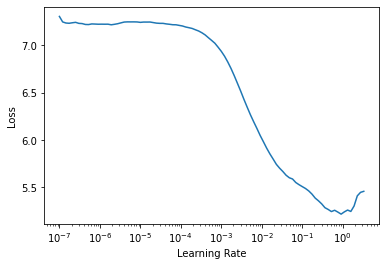

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune(10, 8e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.827464,0.828822,0.753059,01:19


epoch,train_loss,valid_loss,accuracy,time
0,0.376875,0.540082,0.839892,01:19
1,0.430937,0.477462,0.854821,01:19
2,0.443832,1.459797,0.666887,01:19
3,0.413645,0.450336,0.864364,01:19
4,0.364855,0.454252,0.865593,01:20
5,0.316359,0.360606,0.894175,01:19
6,0.242819,0.315355,0.908159,01:19
7,0.184282,0.209949,0.937733,01:19
8,0.127042,0.171711,0.949402,01:22
9,0.099036,0.163501,0.951717,01:21
